## Strategy based on stocks Equity Multiple (EM)

Equity Multiple is ranked for each stock in decreasing order for each month (because we assume companies will tend to mean revert on their EM to meet investors needs)

We compare EM for each stock to its last monthly (21 business days) values and rank them accordingly

Signal is then rank and gaussain transformed in decreasing order as we expect this signal to mean revert


In [2]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [7]:
R.tail(1)

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,ABMD,...,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
2023-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
balance_sheet['Date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet = balance_sheet.droplevel(0).set_index('Date',append=True)
balance_sheet = balance_sheet.reorder_levels(['Date','Ticker'])
balance_sheet = balance_sheet[~balance_sheet.index.duplicated(keep='first')]
balance_sheet.head()

,,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,...,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,propertyPlantAndEquipmentNet,accumulatedDepreciation,netWorkingCapital,netInvestedCapital,commonStockSharesOutstanding
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,462500000.00
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,461764706.00
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,450000000.00
1999-10-31,A,1999-10-31,1999-10-31,USD,5444000000.00,None,None,404000000.00,2062000000.00,3382000000.00,None,...,None,None,5444000000.00,None,1387000000.00,1387000000.00,None,None,None,440000000.00
2000-03-15,A,2000-01-31,2000-03-15,USD,7107000000.00,None,None,560000000.00,2621000000.00,4486000000.00,None,...,None,None,7107000000.00,1410000000.00,1408000000.00,1408000000.00,None,None,None,440000000.00


In [5]:
income_statement = pd.read_parquet('data/US/income_statement.pq')
income_statement['Date'] = pd.to_datetime(income_statement['filing_date'])
income_statement = income_statement.droplevel(0).set_index('Date',append=True)
income_statement = income_statement.reorder_levels(['Date','Ticker'])
income_statement = income_statement[~income_statement.index.duplicated(keep='first')]
income_statement.head()

,,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,74000000.00,None,None,...,None,None,1786000000.00,None,None,None,None,None,None,None
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,157000000.00,None,None,...,None,None,2010000000.00,None,None,None,None,None,None,None
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,135000000.00,None,None,...,None,None,2087000000.00,None,None,None,None,None,None,None
1999-10-31,A,1999-10-31,1999-10-31,USD,None,None,None,None,146000000.00,None,None,...,None,None,2448000000.00,None,None,None,None,None,None,None
2000-03-15,A,2000-01-31,2000-03-15,USD,290000000.00,0.00,202000000.00,0.00,131000000.00,625000000.00,None,...,0.00,71000000.00,2246000000.00,915000000.00,1160000000.00,31000000.00,0.00,0.00,88000000.00,None


In [6]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float).ffill()
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)
EV = mkt_cap + ltdebt  - cash_equiv.fillna(0) ## computing enteprise value
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
EM = EV / ebitda
EM = EM.reindex_like(P).ffill()

In [1]:
pip install yolk


  Created wheel for yolk: filename=yolk-0.4.3-py3-none-any.whl size=24692 sha256=8dcef84850137e34a36f5a4feebe698cb305a7ec1a887eaac34bc1a7acb81ae8
  Stored in directory: c:\users\marti\appdata\local\pip\cache\wheels\44\bc\61\252d76232e6fe2f52b61d22821bf3dd49519cf36048d2bdb7a
Successfully built yolk


You should consider upgrading via the 'c:\Users\marti\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


C:\Users\marti\AppData\Local\Temp\ipykernel_30200\3132997444.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(21).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99) # time serie rank on last 21 business days
C:\Users\marti\AppData\Local\Temp\ipykernel_30200\3132997444.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe                      1.7
Daily Turnover (%)         72.0
Average Daily Pnl (bps)     2.4
dtype: float64

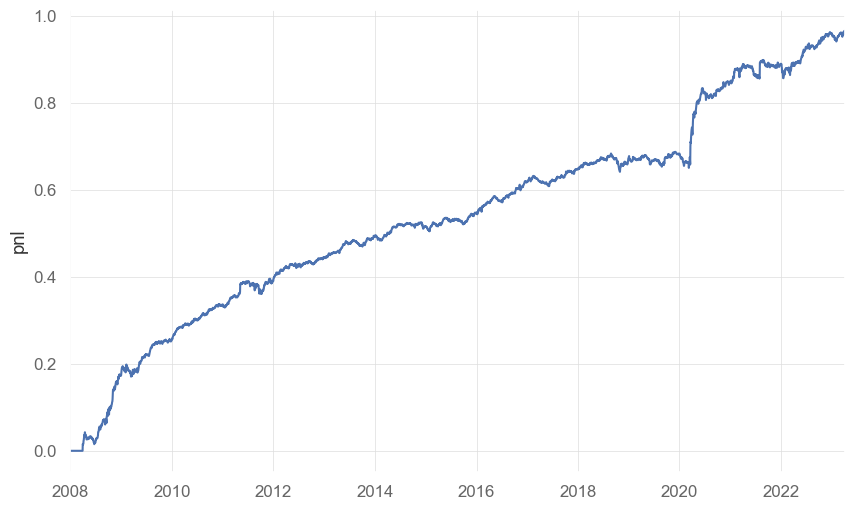

In [7]:
signal = EM.copy()
signal = signal[P].rolling(21).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99) # time serie rank on last 21 business days
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf) # cross sectionnal rank and gaussian transformation
signal[signal.abs()<0.5] = None ## not playing stocks in the middle of the distribution
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)

pnl = (signal[P].shift()*R).sum(1)
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()

plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Daily Turnover (%)':turnover *100 ,'Average Daily Pnl (bps)':pnl.mean()*1e4}).round(1)

<Axes: >

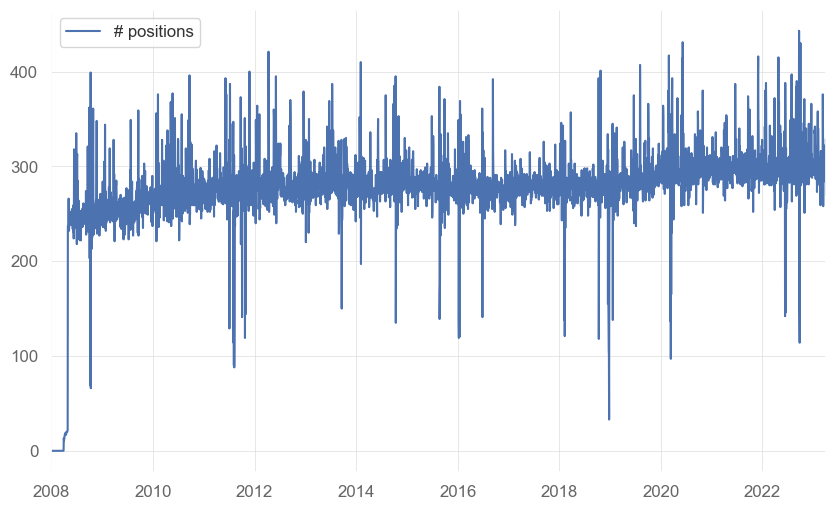

In [8]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

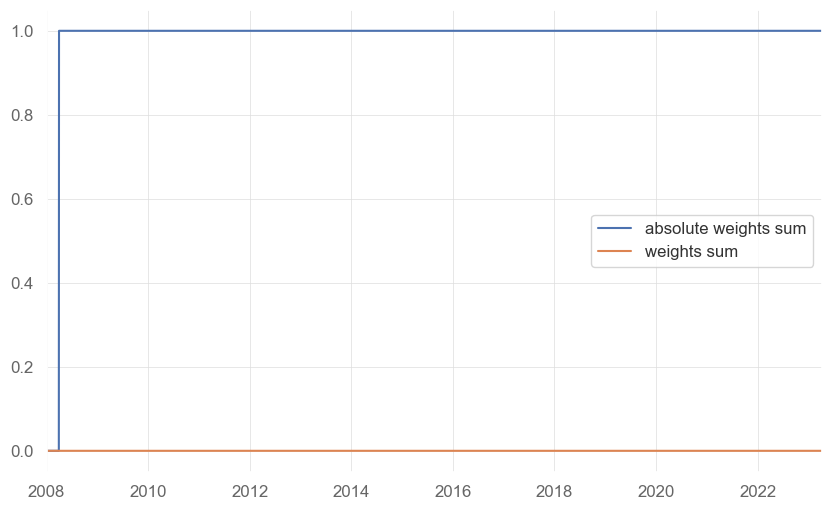

In [9]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)

In [10]:
import quantstats as qs
SP500 = qs.utils.download_returns('SPY')

# report with fancy (and some unuseful) stats
qs.reports.html(pnl, "SPY",title = 'Strategy Equity Multiple')

c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [18]:
pnl.index[0]

Timestamp('2008-01-01 00:00:00')